# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
2. Scroll down to API and click Create New API Token.
3. Open up `kaggle.json` and use the username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

Added '-q' after 'install' to silence the output to have clean view. I already verified that they run without issues.

In [2]:
##DONE##
!pip install -q -U pip
!pip install -q -U setuptools wheel
!pip install -q -U "mxnet<2.0.0" bokeh==2.0.1
!pip install -q autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [3]:
##DONE##
! pip install -q kaggle

### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "g****************"
kaggle_key = "7d*****************************8"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the [bike sharing demand competition](https://www.kaggle.com/c/bike-sharing-demand) and agree to the terms


In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor
%matplotlib inline

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [10]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
predictor = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                time_limit=600,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_161009/"
/usr/local/lib/python3.7/site-packages/autogluon/features/generators/datetime.py:59: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  good_rows = series[~series.isin(bad_rows)].astype(np.int64)
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.


### Review AutoGluon's training run with ranking of models that did the best.

In [14]:
predictor.fit_summary(verbosity=2, show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.029610      10.831290  498.066688                0.001233           0.298338            3       True         14
1   RandomForestMSE_BAG_L2  -53.333334      10.500958  409.832573                0.610971          26.107940            2       True         12
2          LightGBM_BAG_L2  -55.058987      10.175765  407.989607                0.285778          24.264974            2       True         11
3          CatBoost_BAG_L2  -55.587779       9.933308  447.395437                0.043321          63.670803            2       True         13
4        LightGBMXT_BAG_L2  -60.685727      13.464281  436.936805                3.574294          53.212172            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.103518    0.039081         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [15]:
predictions = predictor.predict(test)
predictions.head()

0    23.682514
1    42.842731
2    46.192085
3    50.126865
4    52.739487
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [16]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.663811
std        89.828720
min         3.333329
25%        20.191109
50%        63.969460
75%       166.657486
max       364.006561
Name: count, dtype: float64

In [17]:
# How many negative values do we have?
## No Negative Values
(predictions < 0).sum()

0

In [18]:
# Set them to zero
predictions[predictions<0]=0

### Set predictions to submission dataframe, save, and submit

In [19]:
submission["count"] = predictions
submission.to_csv("AA_submission.csv", index=False)

In [20]:
!kaggle competitions submit -c bike-sharing-demand -f AA_submission.csv -m "AA_first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 389kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [21]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                          status    publicScore  privateScore  
-------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
AA_submission.csv                2022-12-29 16:20:39  AA_first raw submission              complete  1.79118      1.79118       
A_submission_new_hpo.csv         2022-12-29 15:45:13  A_new features with hyperparameters  complete  0.46752      0.46752       
A_submission_new_featuresV3.csv  2022-12-29 13:29:16  A_new featuresV3                     complete  0.51658      0.51658       
A_submission_new_featuresV2.csv  2022-12-29 11:24:21  A_new featuresV2                     complete  0.46548      0.46548       


#### Initial score of `1.79118`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'casual'}>,
        <AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

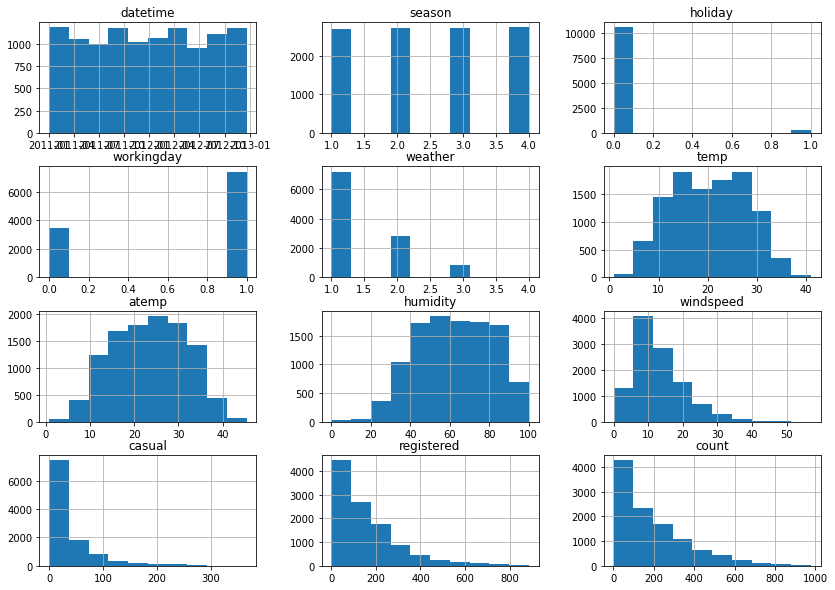

In [22]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(14, 10))

In [23]:
# create a new feature
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [24]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [25]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'casual'}>],
       [<AxesSubplot:title={'center':'registered'}>,
        <AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

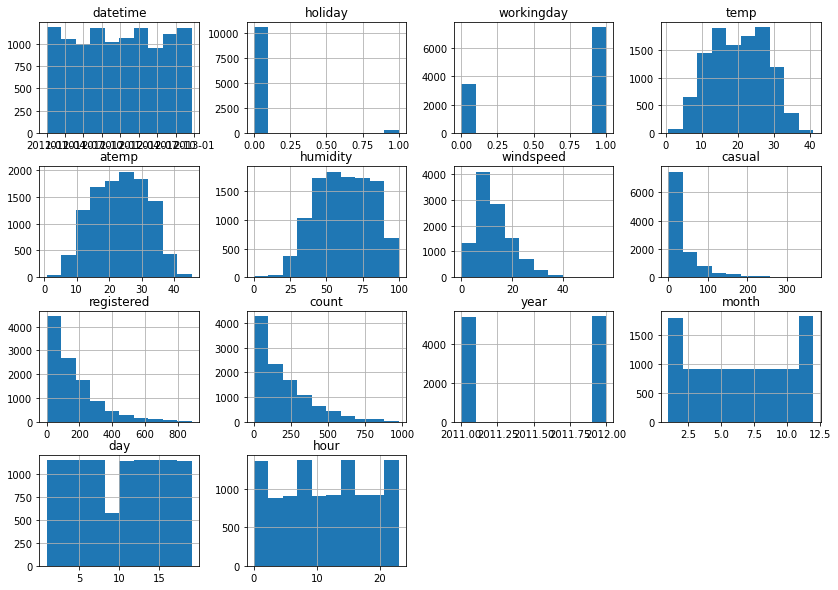

In [26]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(14, 10))

## Step 5: Rerun the model with the same settings as before, just with more features

In [27]:
predictor_new_features = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                time_limit=600,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_162045/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.


In [28]:
predictor_new_features.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.757283      25.069218  551.858683                0.000895           0.389718            3       True         16
1      WeightedEnsemble_L2  -35.890351      21.723675  351.457636                0.000794           0.489838            2       True          9
2     ExtraTreesMSE_BAG_L2  -36.050937      23.760689  407.795046                0.588353           8.018005            2       True         14
3          CatBoost_BAG_L2  -36.163638      23.252567  451.641547                0.080231          51.864506            2       True         13
4          LightGBM_BAG_L2  -36.240596      23.309381  421.784251                0.137044          22.007210            2       True         11
5   RandomForestMSE_BAG_L2  -36.583158      23.780150  426.210979                0.607814          26.433938            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-35.757283,25.069218,551.858683,0.000895,0.389718,3,True,16
1,WeightedEnsemble_L2,-35.890351,21.723675,351.457636,0.000794,0.489838,2,True,9
2,ExtraTreesMSE_BAG_L2,-36.050937,23.760689,407.795046,0.588353,8.018005,2,True,14
3,CatBoost_BAG_L2,-36.163638,23.252567,451.641547,0.080231,51.864506,2,True,13
4,LightGBM_BAG_L2,-36.240596,23.309381,421.784251,0.137044,22.007210,2,True,11
5,RandomForestMSE_BAG_L2,-36.583158,23.780150,426.210979,0.607814,26.433938,2,True,12
6,LightGBMXT_BAG_L2,-36.913109,23.464592,423.228772,0.292256,23.451731,2,True,10
7,LightGBMXT_BAG_L1,-37.097828,15.909221,92.807006,15.909221,92.807006,1,True,3
8,NeuralNetFastAI_BAG_L2,-37.191558,23.654881,443.145307,0.482545,43.368265,2,True,15
9,LightGBM_BAG_L1,-37.692850,5.030059,45.515449,5.030059,45.515449,1,True,4


In [29]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    13.328607
1     6.183785
2     5.569384
3     4.885581
4     4.730910
Name: count, dtype: float32

In [30]:
predictions_new_features.describe()

count    6493.000000
mean      189.430115
std       172.856598
min         3.680516
25%        46.571842
50%       147.035675
75%       280.717407
max       882.516785
Name: count, dtype: float64

In [31]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features<0]=0

In [32]:
# Same submitting predictions
submission_new_features = submission
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("AA_submission_new_features.csv", index=False)

In [33]:
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_features.csv -m "AA_new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 465kB/s]
Successfully submitted to Bike Sharing Demand

In [34]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                          status    publicScore  privateScore  
-------------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
AA_submission_new_features.csv   2022-12-29 16:32:04  AA_new features                      complete  0.47359      0.47359       
AA_submission.csv                2022-12-29 16:20:39  AA_first raw submission              complete  1.79118      1.79118       
A_submission_new_hpo.csv         2022-12-29 15:45:13  A_new features with hyperparameters  complete  0.46752      0.46752       
A_submission_new_featuresV3.csv  2022-12-29 13:29:16  A_new featuresV3                     complete  0.51658      0.51658       


#### New Score of `0.47359`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

The 3 hyperparameters to tune in the first trial are as follows:
- num_boost_round = 100
- num_trials = 8
- time_limit = 660

In [35]:
import autogluon.core as ag

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  
                   'GBM': gbm_options, 
                   'RF': {'n_estimators': 300},
                  } 

hyperparameter_tune_kwargs = { 
    'num_trials': 8,
    'scheduler' : 'local',
    'searcher': 'auto',
}
    
predictor_new_hpo = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                auto_stack=True,
                                                #refit_full='best',
                                                time_limit=660,
                                                hyperparameters = hyperparameters,
                                                hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_163206/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
 88%|████████▊ | 7/8 [03:01<00:25, 25.86s/it]
	No hyperparameter search space specified for RandomForest_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
 88%|████████▊ | 7/8 [03:10<00:27, 27.24s/it]
	No hyperparameter search space specified for RandomForest_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.


In [36]:
predictor_new_hpo.leaderboard()

                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -39.433079       0.002931  345.032289                0.001164           0.505284            3       True         20
1   WeightedEnsemble_L2  -39.736237       0.001186   59.425570                0.000835           0.504658            2       True         10
2    LightGBM_BAG_L2/T7  -39.746591       0.001147  217.373004                0.000134          23.921216            2       True         17
3    LightGBM_BAG_L2/T1  -39.776966       0.001110  216.427728                0.000097          22.975939            2       True         11
4    LightGBM_BAG_L2/T3  -39.803870       0.001158  217.172252                0.000144          23.720464            2       True         13
5    LightGBM_BAG_L2/T8  -39.843926       0.001142  218.653385                0.000129          25.201597            2       True         18
6    LightGBM

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-39.433079,0.002931,345.032289,0.001164,0.505284,3,True,20
1,WeightedEnsemble_L2,-39.736237,0.001186,59.425570,0.000835,0.504658,2,True,10
2,LightGBM_BAG_L2/T7,-39.746591,0.001147,217.373004,0.000134,23.921216,2,True,17
3,LightGBM_BAG_L2/T1,-39.776966,0.001110,216.427728,0.000097,22.975939,2,True,11
4,LightGBM_BAG_L2/T3,-39.803870,0.001158,217.172252,0.000144,23.720464,2,True,13
5,LightGBM_BAG_L2/T8,-39.843926,0.001142,218.653385,0.000129,25.201597,2,True,18
6,LightGBM_BAG_L2/T2,-39.898881,0.001135,216.927272,0.000122,23.475483,2,True,12
7,RandomForest_BAG_L2,-39.945567,0.001142,225.232306,0.000128,31.780518,2,True,19
8,LightGBM_BAG_L2/T5,-40.097195,0.001093,217.325361,0.000080,23.873573,2,True,15
9,LightGBM_BAG_L1/T8,-40.857829,0.000115,23.944593,0.000115,23.944593,1,True,8


In [37]:
# Remember to set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo[predictions_new_hpo<0]=0

In [38]:
# Same submitting predictions
submission_new_hpo = submission
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("AA_submission_new_hpo.csv", index=False)

In [39]:
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_hpo.csv -m "AA_new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 403kB/s]
Successfully submitted to Bike Sharing Demand

In [40]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                           status    publicScore  privateScore  
-------------------------------  -------------------  ------------------------------------  --------  -----------  ------------  
AA_submission_new_hpo.csv        2022-12-29 16:39:11  AA_new features with hyperparameters  complete  0.46987      0.46987       
AA_submission_new_features.csv   2022-12-29 16:32:04  AA_new features                       complete  0.47359      0.47359       
AA_submission.csv                2022-12-29 16:20:39  AA_first raw submission               complete  1.79118      1.79118       
A_submission_new_hpo.csv         2022-12-29 15:45:13  A_new features with hyperparameters   complete  0.46752      0.46752       


#### New Score of `0.46987`

The 3 hyperparameters to tune in the second trial are as follows:
- num_boost_round = 150
- num_trials = 12
- time_limit = 780

In [41]:
import autogluon.core as ag

gbm_options2 = { 
    'num_boost_round': 150,  
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  
}

hyperparameters2 = {  
                   'GBM': gbm_options2, 
                   'RF': {'n_estimators': 300},
                  } 

hyperparameter_tune_kwargs2 = { 
    'num_trials': 12,
    'scheduler' : 'local',
    'searcher': 'auto',
}
    
predictor_new_hpoV2 = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                auto_stack=True,
                                                #refit_full='best',
                                                time_limit=780,
                                                hyperparameters = hyperparameters2,
                                                hyperparameter_tune_kwargs=hyperparameter_tune_kwargs2,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_163913/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
 67%|██████▋   | 8/12 [03:39<01:49, 27.44s/it]
	No hyperparameter search space specified for RandomForest_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
 67%|██████▋   | 8/12 [03:44<01:52, 28.00s/it]
	No hyperparameter search space specified for RandomForest_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.


In [42]:
predictor_new_hpoV2.leaderboard()

                  model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3  -38.674984       0.002483  365.562612                0.000846           0.403200            3       True         22
1    LightGBM_BAG_L2/T5  -38.961783       0.001179  257.208560                0.000085          25.332687            2       True         16
2    LightGBM_BAG_L2/T7  -39.013109       0.001211  255.653027                0.000117          23.777153            2       True         18
3    LightGBM_BAG_L2/T1  -39.014219       0.001184  255.704027                0.000089          23.828153            2       True         12
4   WeightedEnsemble_L2  -39.100368       0.001544   85.531543                0.001075           0.474230            2       True         11
5    LightGBM_BAG_L2/T2  -39.117714       0.001227  255.797967                0.000132          23.922093            2       True         13
6   RandomFor

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-38.674984,0.002483,365.562612,0.000846,0.403200,3,True,22
1,LightGBM_BAG_L2/T5,-38.961783,0.001179,257.208560,0.000085,25.332687,2,True,16
2,LightGBM_BAG_L2/T7,-39.013109,0.001211,255.653027,0.000117,23.777153,2,True,18
3,LightGBM_BAG_L2/T1,-39.014219,0.001184,255.704027,0.000089,23.828153,2,True,12
4,WeightedEnsemble_L2,-39.100368,0.001544,85.531543,0.001075,0.474230,2,True,11
5,LightGBM_BAG_L2/T2,-39.117714,0.001227,255.797967,0.000132,23.922093,2,True,13
6,RandomForest_BAG_L2,-39.145984,0.001224,266.373516,0.000129,34.497642,2,True,21
7,LightGBM_BAG_L2/T3,-39.159605,0.001174,257.629836,0.000080,25.753962,2,True,14
8,LightGBM_BAG_L2/T8,-39.185806,0.001175,258.083507,0.000080,26.207633,2,True,19
9,LightGBM_BAG_L1/T8,-40.002567,0.000125,23.601437,0.000125,23.601437,1,True,8


In [43]:
# Remember to set all negative values to zero
predictions_new_hpoV2 = predictor_new_hpoV2.predict(test)
predictions_new_hpoV2[predictions_new_hpoV2<0]=0

# Same submitting predictions
submission_new_hpoV2 = submission
submission_new_hpoV2["count"] = predictions_new_hpoV2
submission_new_hpoV2.to_csv("AA_submission_new_hpoV2.csv", index=False)

In [44]:
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_hpoV2.csv -m "AA_new features with hyperparametersV2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 364kB/s]
Successfully submitted to Bike Sharing Demand

In [45]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                             status    publicScore  privateScore  
-------------------------------  -------------------  --------------------------------------  --------  -----------  ------------  
AA_submission_new_hpoV2.csv      2022-12-29 16:47:34  AA_new features with hyperparametersV2  complete  0.46846      0.46846       
AA_submission_new_hpo.csv        2022-12-29 16:39:11  AA_new features with hyperparameters    complete  0.46987      0.46987       
AA_submission_new_features.csv   2022-12-29 16:32:04  AA_new features                         complete  0.47359      0.47359       
AA_submission.csv                2022-12-29 16:20:39  AA_first raw submission                 complete  1.79118      1.79118       


#### New hpo 2 Score of `0.54402`

The 3 hyperparameters to tune in the third trial are as follows:
- num_boost_round = 200
- num_trials = 16
- time_limit = 900

In [46]:
import autogluon.core as ag

gbm_options3 = { 
    'num_boost_round': 200,  
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  
}

hyperparameters3 = {  
                   'GBM': gbm_options3, 
                   'RF': {'n_estimators': 300},
                  } 

hyperparameter_tune_kwargs3 = { 
    'num_trials': 16,
    'scheduler' : 'local',
    'searcher': 'auto',
}
    
predictor_new_hpoV3 = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                auto_stack=True,
                                                #refit_full='best',
                                                time_limit=900,
                                                hyperparameters = hyperparameters3,
                                                hyperparameter_tune_kwargs=hyperparameter_tune_kwargs3,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_164736/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
 62%|██████▎   | 10/16 [04:24<02:38, 26.49s/it]
	No hyperparameter search space specified for RandomForest_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
 56%|█████▋    | 9/16 [04:17<03:20, 28.62s/it]
	No hyperparameter search space specified for RandomForest_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.


In [47]:
predictor_new_hpoV3.leaderboard()

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3 -38.055951       0.002588  391.680822                0.000822           0.468636            3       True         25
1   WeightedEnsemble_L2 -38.243884       0.001627   85.660005                0.001129           0.552399            2       True         13
2    LightGBM_BAG_L2/T7 -38.315520       0.001393  302.104550                0.000122          24.228863            2       True         20
3    LightGBM_BAG_L2/T3 -38.420881       0.001391  305.063614                0.000120          27.187927            2       True         16
4    LightGBM_BAG_L2/T1 -38.420948       0.001392  303.437399                0.000121          25.561712            2       True         14
5    LightGBM_BAG_L2/T5 -38.427629       0.001350  303.817819                0.000079          25.942132            2       True         18
6   LightGBM_BAG_L2/

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-38.055951,0.002588,391.680822,0.000822,0.468636,3,True,25
1,WeightedEnsemble_L2,-38.243884,0.001627,85.660005,0.001129,0.552399,2,True,13
2,LightGBM_BAG_L2/T7,-38.315520,0.001393,302.104550,0.000122,24.228863,2,True,20
3,LightGBM_BAG_L2/T3,-38.420881,0.001391,305.063614,0.000120,27.187927,2,True,16
4,LightGBM_BAG_L2/T1,-38.420948,0.001392,303.437399,0.000121,25.561712,2,True,14
5,LightGBM_BAG_L2/T5,-38.427629,0.001350,303.817819,0.000079,25.942132,2,True,18
6,LightGBM_BAG_L2/T10,-38.444884,0.001403,302.591821,0.000131,24.716134,2,True,23
7,LightGBM_BAG_L2/T8,-38.527510,0.001354,304.700657,0.000082,26.824970,2,True,21
8,LightGBM_BAG_L2/T2,-38.569656,0.001384,303.227871,0.000112,25.352184,2,True,15
9,RandomForest_BAG_L2,-38.576041,0.001394,315.079262,0.000123,37.203575,2,True,24


In [48]:
# Remember to set all negative values to zero
predictions_new_hpoV3 = predictor_new_hpoV3.predict(test)
predictions_new_hpoV3[predictions_new_hpoV3<0]=0

# Same submitting predictions
submission_new_hpoV3 = submission
submission_new_hpoV3["count"] = predictions_new_hpoV3
submission_new_hpoV3.to_csv("AA_submission_new_hpoV3.csv", index=False)

In [49]:
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_hpoV3.csv -m "AA_new features with hyperparametersV3"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 409kB/s]
Successfully submitted to Bike Sharing Demand

In [50]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                             status    publicScore  privateScore  
-------------------------------  -------------------  --------------------------------------  --------  -----------  ------------  
AA_submission_new_hpoV3.csv      2022-12-29 16:57:22  AA_new features with hyperparametersV3  complete  0.46966      0.46966       
AA_submission_new_hpoV2.csv      2022-12-29 16:47:34  AA_new features with hyperparametersV2  complete  0.46846      0.46846       
AA_submission_new_hpo.csv        2022-12-29 16:39:11  AA_new features with hyperparameters    complete  0.46987      0.46987       
AA_submission_new_features.csv   2022-12-29 16:32:04  AA_new features                         complete  0.47359      0.47359       


#### New hpo 3 Score of `0.46966`

## Extra Step: Rerun the model with more features

In [51]:
# create a new weekday feature
train["weekday"] = train['datetime'].dt.weekday # 0 for Monday, and 6 for Sunday

test["weekday"] = test['datetime'].dt.weekday # 0 for Monday, and 6 for Sunday

In [52]:
# Transform 'holiday','workingday','month','weekday','hour' to category
category_features = ["holiday", "workingday", "month", "weekday","day", "hour"]

for feature in category_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  category      
 14  day         10886 non-null  category      
 15  hour        10886 non-null  category      
 16  weekday     10886 non-

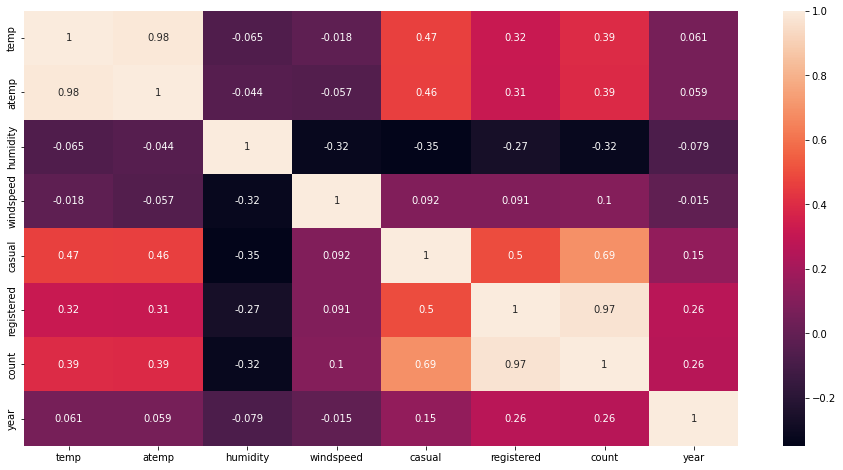

In [54]:
# We already know that the data is clean as we viewed it earlier,
# so lets view the corelation matrix.
import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr()
plt.figure(figsize = (16,8))
ax = sns.heatmap(corr, annot=True)
plt.show()

#### Notes:
- 'temp' and 'atemp' are highly correlated with each other, so we will drop one of them as they provide the same information. Having two columns highly correlated with each other will act as a weighted feature.
- 'windspeed' has a low correlation with 'count', so we can drop it as it will not add value.

In [55]:
train = pd.get_dummies(train, columns = ["season", "weather","weekday"])
test = pd.get_dummies(test, columns = ["season", "weather","weekday"])

In [56]:
# Train
predictor_new_featuresV2 = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime", "atemp", "windspeed"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                time_limit=600,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_165725/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.


In [57]:
predictor_new_featuresV2.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -33.464457      15.061002  520.166721                0.001196           0.415950            3       True         16
1      WeightedEnsemble_L2  -33.523679      12.834421  355.411676                0.001092           0.495801            2       True          9
2          CatBoost_BAG_L2  -33.730400      13.643412  458.518988                0.117825          59.121076            2       True         13
3     ExtraTreesMSE_BAG_L2  -33.841100      14.179525  410.268351                0.653938          10.870439            2       True         14
4          LightGBM_BAG_L2  -34.040736      13.656070  421.952321                0.130483          22.554410            2       True         11
5   RandomForestMSE_BAG_L2  -34.443775      14.157561  427.204846                0.631974          27.806935            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-33.464457,15.061002,520.166721,0.001196,0.415950,3,True,16
1,WeightedEnsemble_L2,-33.523679,12.834421,355.411676,0.001092,0.495801,2,True,9
2,CatBoost_BAG_L2,-33.730400,13.643412,458.518988,0.117825,59.121076,2,True,13
3,ExtraTreesMSE_BAG_L2,-33.841100,14.179525,410.268351,0.653938,10.870439,2,True,14
4,LightGBM_BAG_L2,-34.040736,13.656070,421.952321,0.130483,22.554410,2,True,11
5,RandomForestMSE_BAG_L2,-34.443775,14.157561,427.204846,0.631974,27.806935,2,True,12
6,LightGBMXT_BAG_L1,-34.497460,7.042551,64.787499,7.042551,64.787499,1,True,3
7,LightGBMXT_BAG_L2,-34.976198,13.884300,423.685246,0.358713,24.287335,2,True,10
8,LightGBM_BAG_L1,-35.556875,4.091886,45.263863,4.091886,45.263863,1,True,4
9,ExtraTreesMSE_BAG_L1,-37.862602,0.553566,6.673860,0.553566,6.673860,1,True,7


In [58]:
predictions_new_featuresV2 = predictor_new_featuresV2.predict(test)
predictions_new_featuresV2[predictions_new_featuresV2<0]=0
predictions_new_featuresV2.head()

0    9.238207
1    5.149355
2    5.223672
3    4.706326
4    4.748228
Name: count, dtype: float32

In [59]:
# Save predictions
submission_new_featuresV2 = submission
submission_new_featuresV2["count"] = predictions_new_featuresV2
submission_new_featuresV2.to_csv("AA_submission_new_featuresV2.csv", index=False)

In [60]:
# Submit new features
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_featuresV2.csv -m "AA_new featuresV2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 335kB/s]
Successfully submitted to Bike Sharing Demand

In [61]:
#View Kaggle scores
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                          date                 description                             status    publicScore  privateScore  
--------------------------------  -------------------  --------------------------------------  --------  -----------  ------------  
AA_submission_new_featuresV2.csv  2022-12-29 17:08:25  AA_new featuresV2                       complete  0.42838      0.42838       
AA_submission_new_hpoV3.csv       2022-12-29 16:57:22  AA_new features with hyperparametersV3  complete  0.46966      0.46966       
AA_submission_new_hpoV2.csv       2022-12-29 16:47:34  AA_new features with hyperparametersV2  complete  0.46846      0.46846       
AA_submission_new_hpo.csv         2022-12-29 16:39:11  AA_new features with hyperparameters    complete  0.46987      0.46987       


### Score is `0.42838`

The values of a column have a bigger effect on the result the higher the values are, so it is better to scale the values. We scale 'humidity' and 'temp' columns.

In [62]:
# Categorizes cold, mild, warm, hot temps from temp where:
# Cold = <10 C
# mild = 10-20 C
# warm = 20-30 C
# hot = >30 C
# we will not include 'temp' in the training

import numpy as np

train['temp_categorized'] = np.where(
    train['temp'] < 10, "cold", 
    np.where(train['temp'] <= 20, "mild", 
    np.where(train['temp'] <= 30, "warm", 
    np.where(train['temp'] >30, "hot","NA"))))

test['temp_categorized'] = np.where(
    test['temp'] < 10, "cold", 
    np.where(test['temp'] <= 20, "mild", 
    np.where(test['temp'] <= 30, "warm", 
    np.where(test['temp'] >30, "hot","NA"))))

In [63]:
# Categorizes no-rush-hour and morning, lunch, and evening rush hours, where
# morning_rush: 7-9am (7-9)
# lunch_ruch: 11am-1pm (11-13)
# evening_rush: 5-6pm (17-19)
# no_rush: any time else
# We will keep 'hour' in the training 

# change 'hour' to integer temporary to apply operations 
train["hour"] = train["hour"].astype('uint8')
train['rush_hours'] = np.where(
    (train['hour'] >= 7) & (train['hour'] < 9), "morning_rush", 
    np.where((train['hour'] >=11) & (train['hour'] <13), "lunch_ruch", 
    np.where((train['hour'] >=17) & (train['hour'] <19), "evening_rush", "no_rush")))
train["hour"] = train["hour"].astype('category')

test["hour"] = test["hour"].astype('uint8')
test['rush_hours'] = np.where(
    (test['hour'] >= 7) & (test['hour'] < 9), "morning_rush", 
    np.where((test['hour'] >=11) & (test['hour'] <13), "lunch_ruch", 
    np.where((test['hour'] >=17) & (test['hour'] <19), "evening_rush", "no_rush")))
test["hour"] = test["hour"].astype('category')


In [64]:
## One-hot encode "temp_categorized" and "rush_hours"
train = pd.get_dummies(train, columns = ["temp_categorized","rush_hours"])
test = pd.get_dummies(test, columns = ["temp_categorized","rush_hours"])

In [65]:
# Train
predictor_new_featuresV3 = TabularPredictor(
    problem_type = 'regression',
    learner_kwargs={"ignored_columns": ["casual", "registered", "datetime", "atemp", "windspeed", "temp"]},
    label="count",
    verbosity=1,
    eval_metric="root_mean_squared_error").fit(
                                                train_data=train,
                                                time_limit=600,
                                                presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20221229_170827/"
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.


In [66]:
predictor_new_featuresV3.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L2  -34.158751      12.133668  355.756508                0.000896           0.504528            2       True          9
1      WeightedEnsemble_L3  -34.391922      14.464365  520.952659                0.000936           0.391802            3       True         16
2     ExtraTreesMSE_BAG_L2  -34.731594      13.531632  412.091568                0.664739          12.611287            2       True         14
3          CatBoost_BAG_L2  -34.798274      12.991459  456.241010                0.124567          56.760730            2       True         13
4          LightGBM_BAG_L2  -34.922624      12.999016  422.389062                0.132123          22.908782            2       True         11
5   RandomForestMSE_BAG_L2  -35.057285      13.542000  428.280057                0.675108          28.799777            2       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-34.158751,12.133668,355.756508,0.000896,0.504528,2,True,9
1,WeightedEnsemble_L3,-34.391922,14.464365,520.952659,0.000936,0.391802,3,True,16
2,ExtraTreesMSE_BAG_L2,-34.731594,13.531632,412.091568,0.664739,12.611287,2,True,14
3,CatBoost_BAG_L2,-34.798274,12.991459,456.241010,0.124567,56.760730,2,True,13
4,LightGBM_BAG_L2,-34.922624,12.999016,422.389062,0.132123,22.908782,2,True,11
5,RandomForestMSE_BAG_L2,-35.057285,13.542000,428.280057,0.675108,28.799777,2,True,12
6,LightGBMXT_BAG_L1,-35.153031,5.707366,60.996881,5.707366,60.996881,1,True,3
7,LightGBM_BAG_L1,-35.954241,4.756070,54.737821,4.756070,54.737821,1,True,4
8,LightGBMXT_BAG_L2,-36.025534,13.156702,422.779755,0.289810,23.299475,2,True,10
9,CatBoost_BAG_L1,-39.176194,0.508191,220.373938,0.508191,220.373938,1,True,6


In [67]:
predictions_new_featuresV3 = predictor_new_featuresV3.predict(test)
predictions_new_featuresV3[predictions_new_featuresV3<0]=0

# Save predictions
submission_new_featuresV3 = submission
submission_new_featuresV3["count"] = predictions_new_featuresV3
submission_new_featuresV3.to_csv("AA_submission_new_featuresV3.csv", index=False)

In [68]:
# Submit new features
!kaggle competitions submit -c bike-sharing-demand -f AA_submission_new_featuresV3.csv -m "AA_new featuresV3"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 411kB/s]
Successfully submitted to Bike Sharing Demand

In [69]:
#View Kaggle scores
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                          date                 description                             status    publicScore  privateScore  
--------------------------------  -------------------  --------------------------------------  --------  -----------  ------------  
AA_submission_new_featuresV3.csv  2022-12-29 17:19:27  AA_new featuresV3                       complete  0.51985      0.51985       
AA_submission_new_featuresV2.csv  2022-12-29 17:08:25  AA_new featuresV2                       complete  0.42838      0.42838       
AA_submission_new_hpoV3.csv       2022-12-29 16:57:22  AA_new features with hyperparametersV3  complete  0.46966      0.46966       
AA_submission_new_hpoV2.csv       2022-12-29 16:47:34  AA_new features with hyperparametersV2  complete  0.46846      0.46846       


### Score `0.51985`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

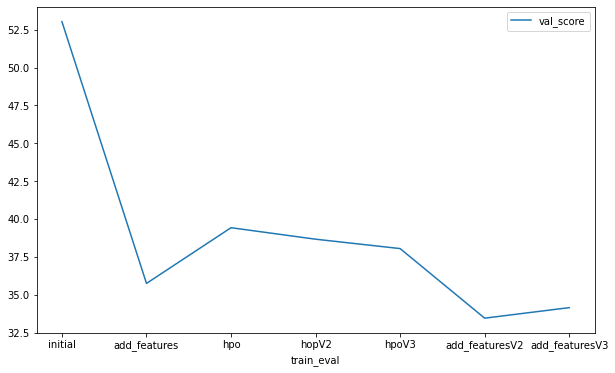

In [77]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)

fig = pd.DataFrame(
    {
        "train_eval": ["initial", "add_features", "hpo","hopV2","hpoV3","add_featuresV2","add_featuresV3"],
        "val_score": [53.029610, 35.757283, 39.433079, 38.674984, 38.055951,33.464457 ,34.158751]
    }
).plot(x="train_eval", y="val_score", figsize=(10, 6)).get_figure()
fig.savefig('model_train_score.png')

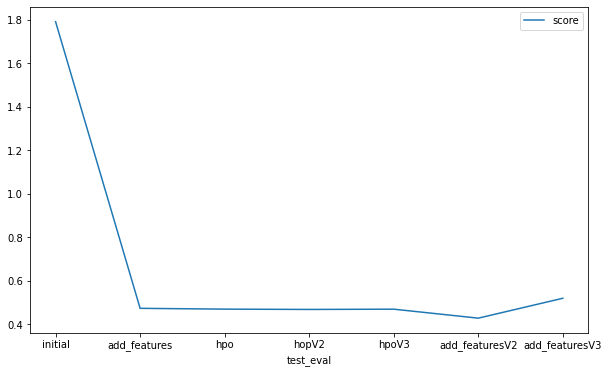

In [75]:
# Take the 5 test scores and create a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo", "hopV2", "hpoV3", "add_featuresV2", "add_featuresV3"],
        "score": [1.79118, 0.47359, 0.46987, 0.46846, 0.46966,0.42838,0.51985]
    }
).plot(x="test_eval", y="score", figsize=(10, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [76]:
# The 3 hyperparameters we tuned and the features we added with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo", "hopV2", "hpoV3","add_featuresV2","add_featuresV3"],
    "time_limit": ["600", "600", "660","780","900","600", "600"],
    "num_boost_round": ["default", "default", "8","12","16","default", "default"],
    "num_trials": ["default", "default", "100","150","200","default", "default"],
    "score": [1.79118, 0.47359, 0.46987, 0.46846, 0.46966,0.42838,0.51985]
})

,model,time_limit,num_boost_round,num_trials,score
0,initial,600,default,default,1.79118
1,add_features,600,default,default,0.47359
2,hpo,660,8,100,0.46987
3,hopV2,780,12,150,0.46846
4,hpoV3,900,16,200,0.46966
5,add_featuresV2,600,default,default,0.42838
6,add_featuresV3,600,default,default,0.51985
